# Statistics

In [925]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

plt.rcParams['figure.figsize'] = 24, 10
plt.style.use('dark_background')

## Functions

In [1312]:
def gauss(x, m , s, A):
    return A * np.exp( - ( (x-m)**2 ) / ( 2 * s**2 ) )

def log_gauss(x,m,s,A):
    return -0.5 * ( np.log(A) + ( ((x-m)**2) / (s**2) ) )

def sim_data(m, s, A, sigma_noise, wl_start, window):

    size = 800
    
    wls     = np.linspace(wl_start, wl_start+window, size)
    noise = sigma_noise * np.random.randn(size)
    peak  = [gauss(x, m, s, A) for x in wls]
    signal = noise+peak

    return wls, signal

def moving_average(x_array, y_array, window):

    new_x      = []
    avr_array = []
    for i in range(window, len(y_array) - window):

        new_x.append(x_array[i])
        
        val = 0
        for j in range(1, window):
            val+= y_array[i+j]
            val+=y_array[i-j]
        val+= y_array[i]
        avr_array.append(val/(window*2 +1))
    
    return new_x, avr_array


def get_likelihood(data, sigma_noise, *args, **kwargs):
    
    x_data, y_data = data
    mean_values = gauss(x_data, *args, **kwargs)
    log_likelihoods = -0.5 * np.log(2 * np.pi * sigma_noise**2) - 0.5 * ((y_data - mean_values) / sigma_noise)**2
    log_likelihood = np.sum(log_likelihoods)
    
    return log_likelihood


def get_mle(data, sigma_noise, m, s, A_range):

    like_arr = []
    for A in A_range:
        like = get_likelihood(data, sigma_noise, m, s, A)
        like_arr.append(like)

    idx = np.argmax(like_arr)
        
    return A_range[idx]


def get_mle_2d(data, sigma_noise, m, s_range, A_range):

    matrix = []

    for A in A_range:
        row = []
        for s in s_range:
            like = get_likelihood(data, sigma_noise, m, s, A)
            row.append(like)
        matrix.append(row)

    return matrix


def grid_it():
    plt.grid(True, which='both', linestyle='-', linewidth=0.75, color='gray')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='lightgray', linestyle='--', linewidth=0.25) 
    plt.legend()

## Simulations

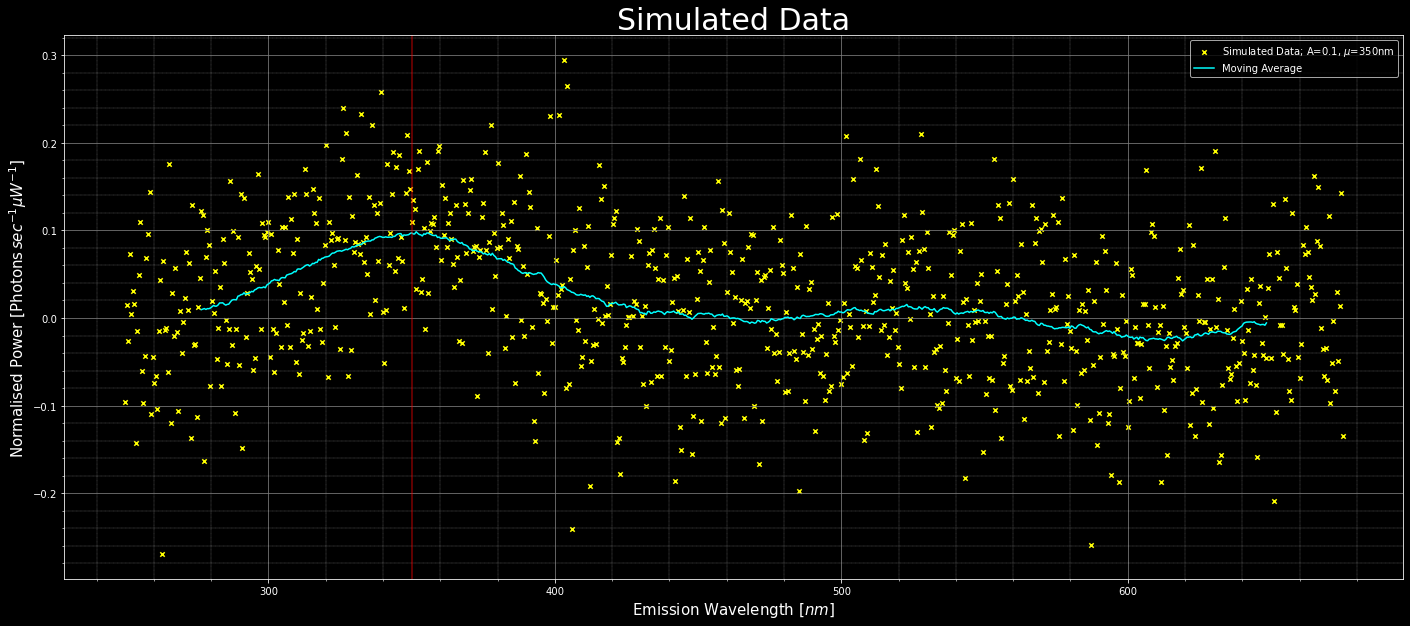

In [1313]:
wl_start = 250; window = 425

m_sim = 350; s_sim = 30; A_sim = 0.1

s_noise = 0.08

x,y = sim_data(m_sim, s_sim, A_sim, s_noise, wl_start, window)
x_avr, y_avr = moving_average(x,y, 50)
plt.scatter(x,y, color = 'yellow', marker = 'x', s =20, label = rf'Simulated Data; A={A_sim}, $\mu$={m_sim}nm')
plt.plot(x_avr, y_avr, color='cyan', label = 'Moving Average')
plt.axvline(x=m_sim, alpha = 0.5, color = 'red')
plt.xlabel(r'Emission Wavelength [$nm$]', fontsize = 15)
plt.ylabel(r'Normalised Power [Photons$ \, sec^{-1} \mu W^{-1}$]', fontsize = 15)
plt.title('Simulated Data', fontsize=30)
grid_it()

In [1311]:
Ts = []
As = np.linspace(0 ,1, 5000)
data = [x,y]

mle = get_mle(data, s_noise, m_sim, s_sim, As)
like_h0 = get_likelihood(data, s_noise, m_sim, s_sim, mle)

for A in As:
    
    like_h1 = get_likelihood(data, s_noise, m_sim, s_sim, A)
    LLR        = -2 * ( like_h1 -  like_h0 )
    Ts.append(LLR)

plt.scatter(As, Ts,  color= 'yellow', marker = 'x', s = 5, label = f'LLR, mle = {np.round(mle,3)}')
plt.xlabel('A', fontsize=20)
plt.ylabel('LLR', fontsize=20)

idx = np.argmin(Ts); min_val = Ts[idx]
plt.axhline(y = min_val + 1, color='cyan', label = r'1$\sigma$', linestyle = '--')
plt.axhline(y = min_val + 4, color='fuchsia', label = r'2$\sigma$', linestyle = '--')
plt.axhline(y = min_val + 9, color='red', label = r'3$\sigma$', linestyle = '--')
plt.axhline(y = min_val + 16, color='green', label = r'4$\sigma$', linestyle = '--')
plt.axhline(y = min_val + 25, color='chartreuse', label = r'5$\sigma$', linestyle = '--')

plt.xlim(mle-0.075, mle+0.075)
plt.ylim(0,mle+25+2)

plt.title(f'A_mle = {np.round(As[idx], 4)}', fontsize=30)

grid_it()

ValueError: operands could not be broadcast together with shapes (5000,) (800,) 

In [1299]:
data = [x,y]
s_range = np.linspace(25, 45,  1000)
A_range = np.linspace(0,0.2, 1000)
matrix = get_mle_2d(data, s_noise, m_sim, s_range, A_range)

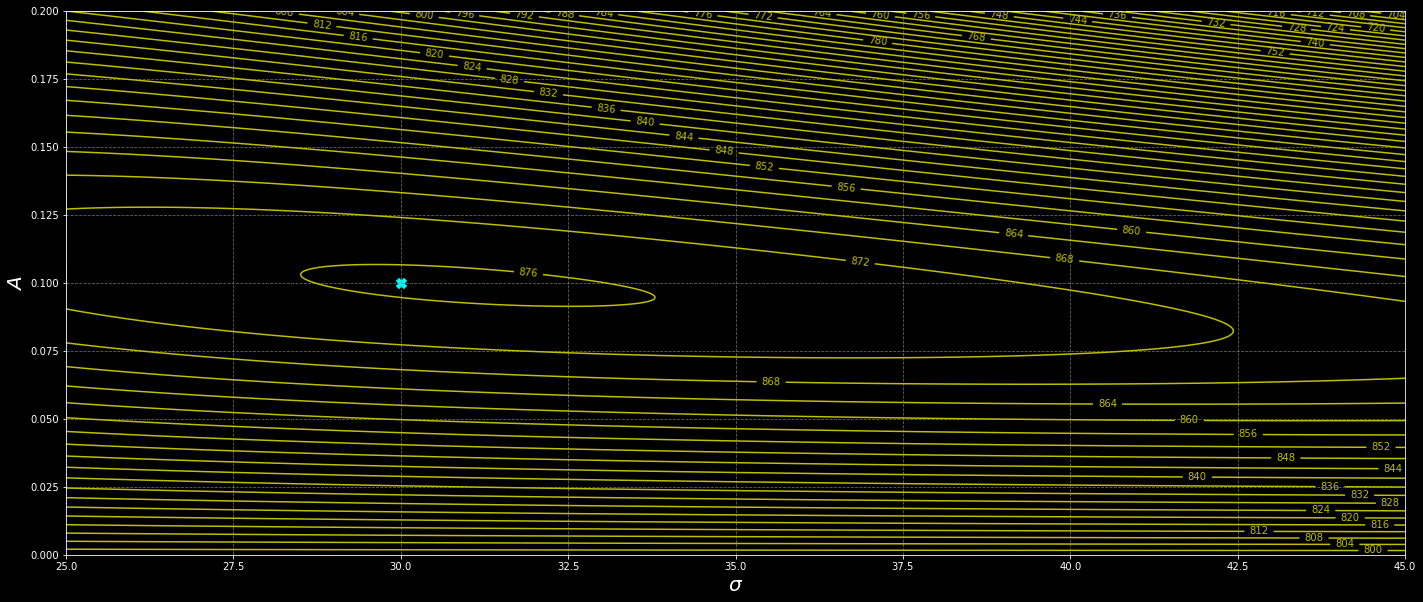

In [1304]:
S, A = np.meshgrid(s_range, A_range)
contour = plt.contour(S, A, matrix, levels=50, colors='y')

# Add labels, title, and a colorbar
plt.clabel(contour, inline=1, fontsize=10)
plt.scatter(s_sim, A_sim, s = 100, marker = 'X', color='cyan')
plt.xlabel(r'$\sigma$', fontsize = 20)
plt.ylabel(r'$A$', fontsize = 20)
plt.grid('on', color = 'grey', alpha = 0.8, linestyle = '--')
plt.show();